In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

bigquery_project = 'BIGQUERY_PROJECT'
service_account_json_path = "YOUR_SERVICE_ACCOUNT_JSON_PATH"
client = bigquery.Client.from_service_account_json(service_account_json_path, project=bigquery_project)

In [5]:


# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'
ORANGE2 = '#F79747'

# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

In [6]:

# Define your SQL query to get total orders and total users for each month if you don't have data.csv
query = """
WITH raw AS
(
  SELECT
    user_id,
    DATE_TRUNC(MIN(DATE(TIMESTAMP_MICROS(event_timestamp))), month) AS user_first_engagement_month,
  FROM `PROJECT_ID.analytics_1234567890.events_*`
  GROUP BY 1
)
SELECT 
    DATE_TRUNC(DATE(TIMESTAMP_MICROS(event_timestamp)), month) as month,
    COUNT(DISTINCT user_id) AS total_users,
    COUNT(DISTINCT CASE WHEN event_name = 'in_app_purchase' THEN user_id ELSE NULL END) total_order,
    COUNT(DISTINCT user_id) AS total_users,
    COUNT(DISTINCT CASE 
        WHEN raw.user_first_engagement_month = DATE_TRUNC(DATE(TIMESTAMP_MICROS(event_timestamp)), month) THEN user_id 
        ELSE NULL END) AS new_users,
    COUNT(DISTINCT CASE 
        WHEN raw.user_first_engagement_month < DATE_TRUNC(DATE(TIMESTAMP_MICROS(event_timestamp)), month) THEN user_id 
        ELSE NULL END) AS old_users
FROM `PROJECT_ID.analytics_1234567890.events_*`
LEFT JOIN raw USING(user_id)
GROUP BY month
ORDER BY month
"""

# Run the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()


In [16]:
# Attempt to load data from CSV, if you don't have data on bigquery
try:
    df = pd.read_csv('./data/data.csv')
except FileNotFoundError:
    print("CSV file not found then you can using simulated data instead.")
# Display dataframe
df.head(10)

CSV file not found. Using simulated data instead.


,month,total_users,total_order,new_users,old_users
0,2024-01-01,2764,1888,1591,1173
1,2024-02-01,1471,1664,1197,274
2,2024-03-01,3583,517,1380,2203
3,2024-04-01,2354,1276,1497,857
4,2024-05-01,4458,2481,1454,3004
5,2024-06-01,4897,1226,793,4104
6,2024-07-01,3968,2823,1690,2278
7,2024-08-01,3592,1193,626,2966
8,2024-09-01,2186,2438,728,1458
9,2024-10-01,2223,2486,1693,530


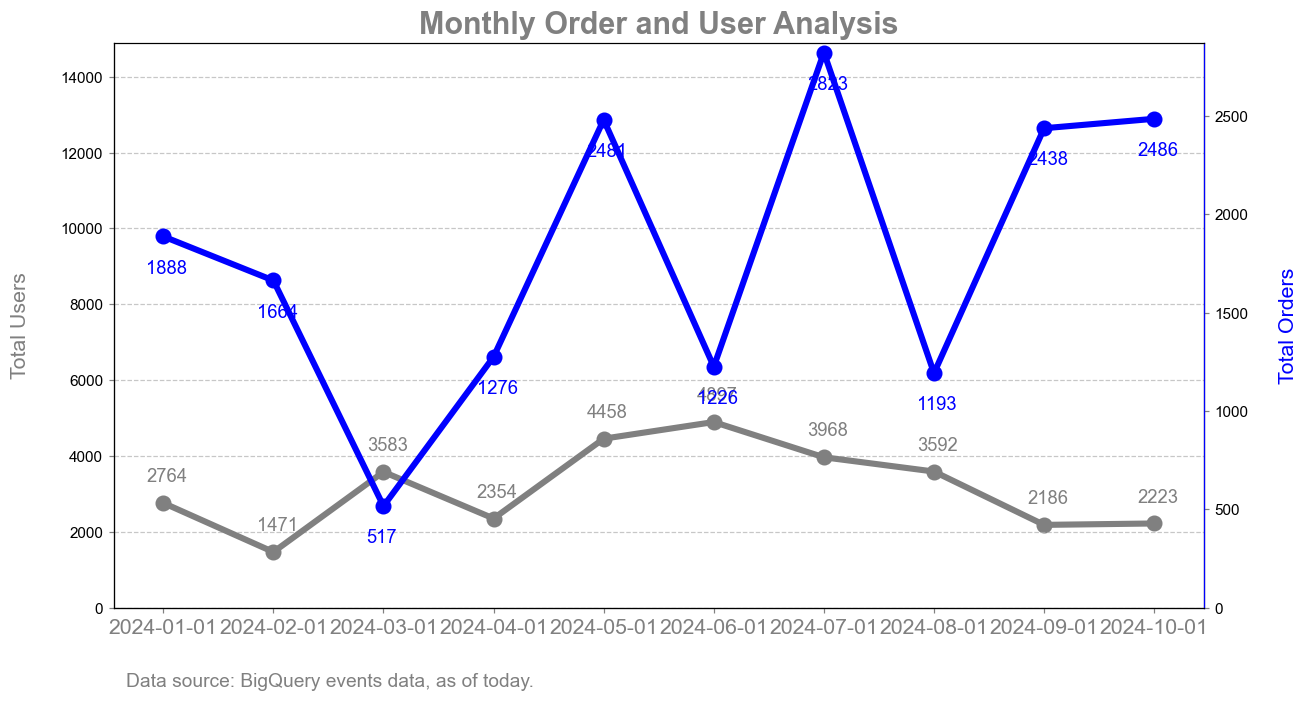

In [23]:
# Extract months and data for plotting
X = df['month'].tolist()
Y = df['total_order'].tolist()
Z = df['total_users'].tolist()

# Create new figure
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=110)

# Tune the subplot layout by setting sides of the figure
fig.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)

# Draw total users line with markers on ax1
ax1.plot(range(len(X)), Z, linewidth=4, color='gray', label='Total Users')  
ax1.scatter(range(len(X)), Z, s=90, color='gray', clip_on=False)

# Create a second y-axis for total orders
ax2 = ax1.twinx()
ax2.plot(range(len(X)), Y, linewidth=4, color='blue', label='Total Orders')
ax2.scatter(range(len(X)), Y, s=90, color='blue', clip_on=False)

# Annotate total users
for i, v in enumerate(Z):
    ax1.annotate(str(v),
                 (i, v),
                 xytext=(-11, 14),
                 textcoords='offset points',
                 color='gray',
                 fontsize=12)

# Annotate total orders
for i, v in enumerate(Y):
    ax2.annotate(str(v),
                 (i, v),
                 xytext=(-11, -24),
                 textcoords='offset points',
                 color='blue',
                 fontsize=12)

# Set limits for y-axes
ax1.set_ylim([0, max(Z) + 10000])  # Adjust the limit for total_users
ax2.set_ylim([0, max(Y) + 50])      # Adjust the limit for total_orders

# Set properties for axes object
plt.setp(ax1,
         xticks=list(range(len(X))),
         xticklabels=X)

# Configure x, y tick labels appearance
for i in ax1.get_xticklabels():
    i.set_fontsize(14)
    i.set_color('gray')

# Change the appearance of ticks, tick labels, and gridlines
ax1.tick_params(bottom='on', color='gray')
ax2.tick_params(right='on', color='gray')

# Change ticks and spines colors
ax1.spines['left'].set_color('gray')
ax2.spines['right'].set_color('blue')
ax1.spines['bottom'].set_color('gray')

# Remove chart border
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(False)

# Add gridlines for better readability
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Title the axis
ax1.set_ylabel('Total Users', fontsize=14, color='gray', labelpad=20)
ax2.set_ylabel('Total Orders', fontsize=14, color='blue', labelpad=20)

# Title the plot
ax1.set_title('Monthly Order and User Analysis', fontsize=20, color='gray', weight='bold')

# Add footnote to the plot with data sources
plt.figtext(0.1, -0.05, 'Data source: BigQuery events data, as of today.', fontsize=12.5, color='gray')

# Show plot
plt.tight_layout()
plt.show()


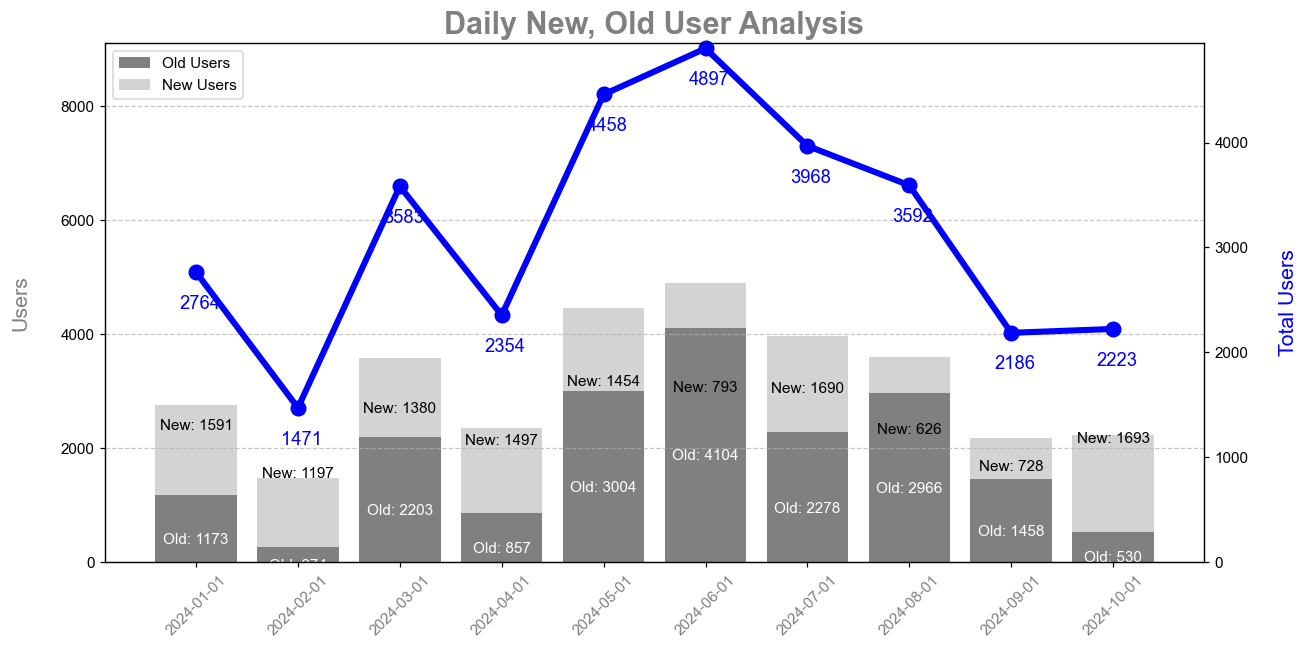

In [21]:
# Extract dates and data for plotting
X = df['month'].tolist()  # Sử dụng event_date thay vì month
Y = df['total_users'].tolist()
Z = df['total_users'].tolist()
new_users = df['new_users'].tolist()
old_users = df['old_users'].tolist()

# Create new figure with additional bar chart for users
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=110)

# Plot stacked bar chart for new and old users
ax1.bar(range(len(X)), old_users, color='gray', label='Old Users')
ax1.bar(range(len(X)), new_users, bottom=old_users, color='lightgray', label='New Users')

# Plot total orders on secondary y-axis (line chart)
ax2 = ax1.twinx()
ax2.plot(range(len(X)), Y, linewidth=4, color='blue', label='Total Users')
ax2.scatter(range(len(X)), Y, s=90, color='blue', clip_on=False)

# Annotate values for new and old users
for i, (n, o) in enumerate(zip(new_users, old_users)):
    ax1.annotate(f'New: {n}', (i, n + o / 2), xytext=(0, 5), textcoords='offset points', ha='center', color='black', fontsize=10)
    ax1.annotate(f'Old: {o}', (i, o / 2), xytext=(0, -10), textcoords='offset points', ha='center', color='white', fontsize=10)

# Annotate total orders
for i, v in enumerate(Y):
    ax2.annotate(str(v), (i, v), xytext=(-11, -24), textcoords='offset points', color='blue', fontsize=12)

# Set limits for y-axes
ax1.set_ylim([0, max(new_users + old_users) + 5000])
ax2.set_ylim([0, max(Y) + 50])

# Set properties for X-axis (dates instead of months)
plt.setp(ax1,
         xticks=list(range(len(X))),
         xticklabels=X)

# Rotate the x-axis labels for better readability if needed
for i in ax1.get_xticklabels():
    i.set_fontsize(10)
    i.set_color('gray')
    i.set_rotation(45)  # Rotate for better readability

# Legends, grid, and labels
ax1.legend(loc='upper left')
ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

# Titles and labels
ax1.set_ylabel('Users', fontsize=14, color='gray', labelpad=20)
ax2.set_ylabel('Total Users', fontsize=14, color='blue', labelpad=20)
ax1.set_title('Daily New, Old User Analysis', fontsize=20, color='gray', weight='bold')

plt.tight_layout()
plt.show()
